In [1]:
import sys
import os
# Add the 'project' directory to the path
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import pickle
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from project_code.data.load_data import load_dataframes
from project_code.data.prepare_data_sklearn import get_features_targets
from project_code.plotters.infeasibility import infeasibility_flag_to_text, method_labels

# Loading data and results

## Load data

In [4]:
dataset_name = 'final'
dataset_name += '_taxonomy'
dataset_name += '_ecocodes'

bio_dataset_name = 'biologist_no_pub_age'

# Load the data
dataset_folder = f'../data/processed/'
dfs, col_types = load_dataframes(dataset_name=dataset_name, data_split='train_test', datasets_folder=dataset_folder)
data = get_features_targets(dfs, col_types)

## Load results

In [5]:
results_folder = f'../results/'
feasibility_results_folder = os.path.join(results_folder, 'feasibility')
feas_df_dict = {}
for file in os.listdir(feasibility_results_folder):
    model_name = file.split('_feasibility.csv')[0]
    feas_df_dict[model_name] = pd.read_csv(os.path.join(feasibility_results_folder, file), index_col=0)
    feas_df_dict[model_name]['infeasibility_flag'] = feas_df_dict[model_name]['infeasibility_flag'].astype(str)
    feas_df_dict[model_name]['feasible'] = feas_df_dict[model_name]['feasible'].astype(bool)


print(*feas_df_dict.keys(), sep='\n')

AmP
AmP_minimum
BijectionMethod
MLPSC
MLP
SRTaxo1NN
Taxo1NN


### Assign errors in Bijection method to infeasibility causes

In [6]:
bijection_stats_df = pd.read_csv(f"{results_folder}/bijection_method/bijection_stats.csv", index_col=0)
bijection_stats_df['get_tj_error'] = bijection_stats_df['get_tj_error'].astype(bool)
for species in feas_df_dict['BijectionMethod'].index.values:
    if feas_df_dict['BijectionMethod'].at[species, 'infeasibility_flag'] == 'error':
        if bijection_stats_df.at[species, 'get_tj_error']:
            feas_df_dict['BijectionMethod'].at[species, 'infeasibility_flag'] = '7'
        else:
            feas_df_dict['BijectionMethod'].at[species, 'infeasibility_flag'] = '6'

### Add species where bijection method failed

In [7]:
species_bijection_failed = feas_df_dict['AmP_minimum'].index.difference(feas_df_dict['BijectionMethod'].index).values
bijection_failed_df = pd.DataFrame(index=species_bijection_failed, columns=feas_df_dict['BijectionMethod'].columns)
bijection_failed_df['infeasibility_flag'] = 'failed'
bijection_failed_df['feasible'] = False
bijection_failed_df['data_split'] = feas_df_dict['AmP']['data_split']
bijection_failed_df['error_message'] = 'failed'
feas_df_dict['BijectionMethod'] = pd.concat([feas_df_dict['BijectionMethod'], bijection_failed_df])
feas_df_dict['BijectionMethod']

,data_split,feasible,infeasibility_flag,error_message
Abbottina_rivularis,train,True,0,NaN
Ablennes_hians,test,True,0,NaN
Acanthochromis_polyacanthus,train,True,0,NaN
Acanthoclinus_littoreus,train,True,0,NaN
Acanthocybium_solandri,train,True,0,NaN
...,...,...,...,...
Zonotrichia_capensis,train,False,failed,failed
Zonotrichia_leucophrys,train,False,failed,failed
Zonotrichia_querula,train,False,failed,failed
Zosterops_lateralis,train,False,failed,failed


In [8]:
feas_df_dict['AmP'].loc[feas_df_dict['AmP']['infeasibility_flag'] != '0', 'infeasibility_flag']

Row
Branta_leucopsis           5
Eucinostomus_gula          1
Sarda_sarda                1
Systellura_longirostris    5
Name: infeasibility_flag, dtype: object

In [9]:
feas_df = pd.concat(feas_df_dict).reset_index(level=0, names='method')
feas_df.replace(to_replace='val', value='train', inplace=True)
feas_df

,method,data_split,feasible,infeasibility_flag,error_message
Abbottina_rivularis,AmP,train,True,0,NaN
Ablennes_hians,AmP,test,True,0,NaN
Abramis_brama,AmP,train,True,0,NaN
Abroscopus_superciliaris,AmP,train,True,0,NaN
Acanthis_flammea,AmP,train,True,0,NaN
...,...,...,...,...,...
Anolis_gundlachi,Taxo1NN,test,True,0,NaN
Neotrygon_kuhlii,Taxo1NN,test,True,0,NaN
Cinnyris_osea,Taxo1NN,test,True,0,NaN
Bathyraja_parmifera,Taxo1NN,test,True,0,NaN


In [10]:
infeasibility_flag_to_text

{'0': 'Feasible',
 'failed': 'Method failed',
 '1': 'Non-positive parameters',
 '2': '$\\kappa > 1$',
 '3': 'Efficiencies greater than 1',
 '4': 'Non-increasing maturity levels',
 '6': 'Unable to reach birth',
 '7': 'Unable to reach metamorphosis',
 '5': 'Unable to reach puberty',
 'timeout': 'Time limit reached',
 'error': 'Error'}

# Results

In [16]:
method_list = ['BijectionMethod', 'MLP', 'MLPSC', 'Taxo1NN', 'SRTaxo1NN']

## Number of infeasible solutions

In [11]:
feasible_counts = {}
for i, ds in enumerate(['train', 'test']):
    feasible_counts[ds] = feas_df.loc[feas_df['data_split'] == ds, ['method', 'infeasibility_flag']].value_counts().sort_index().reset_index()
    feasible_counts[ds]['infeasibility_reason'] = feasible_counts[ds]['infeasibility_flag'].map(infeasibility_flag_to_text)

In [12]:
feas_df[feas_df['infeasibility_flag'] != '0']['infeasibility_flag'].value_counts()

infeasibility_flag
failed     1342
1            44
5            15
6            11
timeout       3
4             2
Name: count, dtype: int64

In [13]:
feasible_counts['train'].groupby(['method', 'infeasibility_reason']).sum()

infeasibility_flag  count
method          infeasibility_reason                             
AmP             Feasible                                 0   1997
                Non-positive parameters                  1      1
                Unable to reach puberty                  5      2
AmP_minimum     Feasible                                 0   2000
BijectionMethod Feasible                                 0    810
                Method failed                       failed   1142
                Non-positive parameters                  1     36
                Time limit reached                 timeout      3
                Unable to reach birth                    6      6
                Unable to reach puberty                  5      3
MLP             Feasible                                 0   1997
                Unable to reach birth                    6      1
                Unable to reach puberty                  5      2
MLPSC           Feasible                                 0   1992
                Unable to reach birth                    6      1
                Unable to reach puberty                  5      7
SRTaxo1NN       Feasible                                 0   2000
Taxo1NN         Feasible                                 0   2000

## Infeasible solutions species list 

In [14]:
df = feas_df_dict['MLP']
df.loc[df['infeasibility_flag'] != '0', ['infeasibility_flag', 'data_split']].sort_values(by=['infeasibility_flag', 'data_split'])

,infeasibility_flag,data_split
Row,,
Branta_leucopsis,5,train
Systellura_longirostris,5,train
Chiroxiphia_lanceolata,6,train


In [37]:
df = feas_df_dict['MLPSC']
df.loc[df['infeasibility_flag'] != '0', ['infeasibility_flag', 'data_split']].sort_values(by=['infeasibility_flag', 'data_split'])

,infeasibility_flag,data_split
Row,,
Trichomycterus_itacarambiensis,4,test
Cygnus_olor,5,train
Psophia_leucoptera,5,train
Dryocopus_pileatus,5,train
Branta_leucopsis,5,train
Sterna_paradisaea,5,train
Antigone_rubicunda,5,train
Systellura_longirostris,5,train
Chiroxiphia_lanceolata,6,train


## Plots

### Bar plots

C:\Users\diogo\AppData\Local\Temp\ipykernel_40280\1273015793.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
C:\Users\diogo\AppData\Local\Temp\ipykernel_40280\1273015793.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


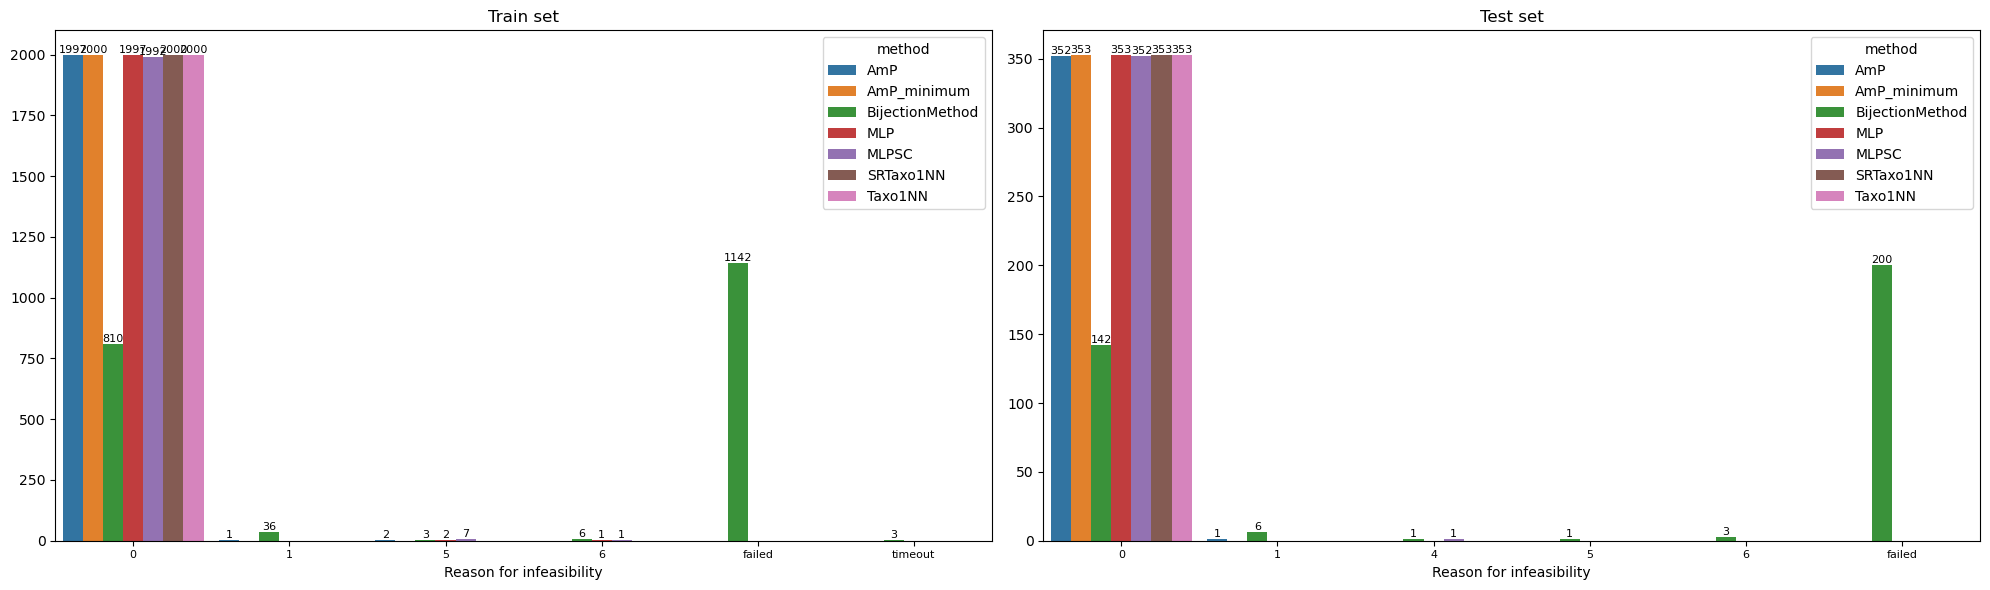

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), tight_layout=True)
for i, ds in enumerate(['train', 'test']):
    ax = axes[i]
    
    sns.barplot(data=feasible_counts[ds], x='infeasibility_flag', y='count', hue='method', ax=ax,
                width=0.9,)
    ax.set_title(f'{ds.capitalize()} set')
    ax.set_xlabel('Reason for infeasibility')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    for j in range(len(feas_df_dict)):
        ax.bar_label(ax.containers[j], fontsize=8)

## LaTeX Tables

In [18]:
list(infeasibility_flag_to_text.values()).index('Error')

10

### Only occurrences table

In [35]:
method = 'BijectionMethod'
m_inf_df = pd.concat({ds: feasible_counts[ds].set_index(['method', 'infeasibility_reason']).loc[method, 'count'] for ds in ['train', 'test']}, axis=1)
m_inf_df = m_inf_df.reindex([i for i in infeasibility_flag_to_text.values() if i in m_inf_df.index])
print(f"Feasible %: {m_inf_df.loc['Feasible'].sum()/len(feas_df_dict['AmP_minimum']) * 100:.1f} %")
print(f"Fail %: {m_inf_df.loc['Method failed'].sum()/len(feas_df_dict['AmP_minimum']) * 100:.1f} %")
m_inf_df

Feasible %: 40.5 %
Fail %: 57.0 %


,train,test
infeasibility_reason,,
Feasible,810.0,142.0
Method failed,1142.0,200.0
Non-positive parameters,36.0,6.0
Non-increasing maturity levels,NaN,1.0
Unable to reach birth,6.0,3.0
Unable to reach puberty,3.0,1.0
Time limit reached,3.0,NaN


In [ ]:
# Set the index to 'method' and 'infeasibility_reason'
# Sort the index
for method in method_list:
    m_inf_df = pd.concat({ds: feasible_counts[ds].set_index(['method', 'infeasibility_reason']).loc[method, 'count'] for ds in ['train', 'test']}, axis=1)
    m_inf_df = m_inf_df.reindex([i for i in infeasibility_flag_to_text.values() if i in m_inf_df.index])
    # Get number of infeasibility reasons
    n_inf_reasons = len(m_inf_df)
    # Print 
    for i, (reason, values) in enumerate(m_inf_df.iterrows()):
        line = ''
        if i == 0:
            # Print multirow with method name
            line += f"\\multirow{{{n_inf_reasons}}}{{7em}}{{{method_labels[method]}}}"
        line += f" & {reason}"
        for ds in ['train', 'test']:
            if np.isnan(values[ds]):
                count = '-'
            else:
                count = int(values[ds])
            line += f' & {count}'
        # Sucess rate
        line += " & "
        if i == 0:
            sucess_rate = m_inf_df.loc['Feasible'].sum()/len(feas_df_dict['AmP_minimum']) * 100
            line += f"\\multirow{{{n_inf_reasons}}}{{4em}}{{{sucess_rate:.1f}\%}}"            

        line += ' \\\\'
        print(line)
    print('\\specialrule{0.2pt}{0pt}{0pt}')
#df

\multirow{7}{7em}{Bijection} & Feasible & 810 & 142 & \multirow{7}{3em}{40.5\%} \\
 & Method failed & 1142 & 200 &  \\
 & Non-positive parameters & 36 & 6 &  \\
 & Non-increasing maturity levels & - & 1 &  \\
 & Unable to reach birth & 6 & 3 &  \\
 & Unable to reach puberty & 3 & 1 &  \\
 & Time limit reached & 3 & - &  \\
\specialrule{0.2pt}{0pt}{0pt}
\multirow{3}{7em}{HC-NN} & Feasible & 1997 & 353 & \multirow{3}{3em}{99.9\%} \\
 & Unable to reach birth & 1 & - &  \\
 & Unable to reach puberty & 2 & - &  \\
\specialrule{0.2pt}{0pt}{0pt}
\multirow{4}{7em}{SC-NN} & Feasible & 1992 & 352 & \multirow{4}{3em}{99.6\%} \\
 & Non-increasing maturity levels & - & 1 &  \\
 & Unable to reach birth & 1 & - &  \\
 & Unable to reach puberty & 7 & - &  \\
\specialrule{0.2pt}{0pt}{0pt}
\multirow{1}{7em}{Taxo1NN} & Feasible & 2000 & 353 & \multirow{1}{3em}{100.0\%} \\
\specialrule{0.2pt}{0pt}{0pt}
\multirow{1}{7em}{SR-Taxo1NN} & Feasible & 2000 & 353 & \multirow{1}{3em}{100.0\%} \\
\specialrule{0.2pt

### Complete table

In [23]:
infeas_table_df_dict = {'train': None, 'test': None}
for ds in ['train', 'test']:
    pivot_feas_counts = feasible_counts[ds].pivot(index='infeasibility_flag', columns='method', values='count').fillna(0).astype(int)
    infeas_df = pd.DataFrame(
        index=infeasibility_flag_to_text.values(),
        columns=method_list,
        )
    for method in infeas_df.columns:
        if method not in pivot_feas_counts.columns:
            infeas_df[method] = 0
            continue
        for flag, reason in infeasibility_flag_to_text.items():
            infeas_df.loc[reason, method] = pivot_feas_counts.loc[flag, method] if flag in pivot_feas_counts.index else 0
    infeas_table_df_dict[ds] = infeas_df
infeas_df

,BijectionMethod,MLP,MLPSC,Taxo1NN,SRTaxo1NN
Feasible,142,353,352,353,353
Method failed,200,0,0,0,0
Non-positive parameters,6,0,0,0,0
$\kappa > 1$,0,0,0,0,0
Efficiencies greater than 1,0,0,0,0,0
Non-increasing maturity levels,1,0,1,0,0
Unable to reach birth,3,0,0,0,0
Unable to reach metamorphosis,0,0,0,0,0
Unable to reach puberty,1,0,0,0,0
Time limit reached,0,0,0,0,0


In [24]:
for i, ds in enumerate(['train', 'test']):
    print(f"% {ds.capitalize()} set")
    # Print the header
    print('\\toprule')
    line = 'Infeasibility reason'
    for method in method_list:
        if method in feasible_counts[ds]['method'].values:
            line += f" & {method_labels[method]}"
    print(line)
    print('\\\\ \n\\midrule\n')

    # Print the counts for each infeasibility reason
    for reason in infeasibility_flag_to_text.values():
        formatted_reason = reason.replace('\n', '')
        line = f"{formatted_reason} "
        for method in method_list:
            count = infeas_table_df_dict[ds].loc[reason, method]
            if count == 0:
                count = '--'
            line += f" & {count}"
        line += " \\\\"
        print(line)
    print("\n\\bottomrule \n\n")

% Train set
\toprule
Infeasibility reason & Bijection & HC-NN & SC-NN & Taxo1NN & SR-Taxo1NN
\\ 
\midrule

Feasible  & 810 & 1997 & 1992 & 2000 & 2000 \\
Method failed  & 1142 & -- & -- & -- & -- \\
Non-positive parameters  & 36 & -- & -- & -- & -- \\
$\kappa > 1$  & -- & -- & -- & -- & -- \\
Efficiencies greater than 1  & -- & -- & -- & -- & -- \\
Non-increasing maturity levels  & -- & -- & -- & -- & -- \\
Unable to reach birth  & 6 & 1 & 1 & -- & -- \\
Unable to reach metamorphosis  & -- & -- & -- & -- & -- \\
Unable to reach puberty  & 3 & 2 & 7 & -- & -- \\
Time limit reached  & 3 & -- & -- & -- & -- \\
Error  & -- & -- & -- & -- & -- \\

\bottomrule 


% Test set
\toprule
Infeasibility reason & Bijection & HC-NN & SC-NN & Taxo1NN & SR-Taxo1NN
\\ 
\midrule

Feasible  & 142 & 353 & 352 & 353 & 353 \\
Method failed  & 200 & -- & -- & -- & -- \\
Non-positive parameters  & 6 & -- & -- & -- & -- \\
$\kappa > 1$  & -- & -- & -- & -- & -- \\
Efficiencies greater than 1  & -- & -- & -- & -